# Source of Dataset
This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). 

# Objective of the Project:
The prediction task is to determine whether a person makes over $50K a year.



# weights on the Current Population Survey (CPS) files
The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:
1. A single cell estimate of the population 16+ for each state.
2. Controls for Hispanic Origin by age and sex.
3. Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. 
The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. 

People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state

In [1]:
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline

#SCORE CHECKERS-Classifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

#Model building libraries
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier


#EDA libraries
from scipy.stats import zscore
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, power_transform

#Hyperparametertuning libraries
from sklearn.model_selection import GridSearchCV

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")


#libraries for regularisation
from sklearn.linear_model import Ridge,Lasso,RidgeCV,LassoCV

#Library for saving data
import pickle


In [2]:
df=pd.read_csv('census_income.csv')

#show all columns in dataframe
pd.set_option('display.max_columns', None)
df.head(5)

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [3]:
df.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


1. There are 15 columns
2. Age,Fnlwgt,Education_num,Capital_gain,Capital_loss and Hours_per_week are intger values, the others are string datas 

# Statistical data analysis

In [5]:
df.describe(include='all')

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
count,32560.000000,32560,3.256000e+04,32560,32560.000000,32560,32560,32560,32560,32560,32560.000000,32560.000000,32560.000000,32560,32560
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27815,21789,NaN,NaN,NaN,29169,24719
mean,38.581634,NaN,1.897818e+05,NaN,10.080590,NaN,NaN,NaN,NaN,NaN,1077.615172,87.306511,40.437469,NaN,NaN
std,13.640642,NaN,1.055498e+05,NaN,2.572709,NaN,NaN,NaN,NaN,NaN,7385.402999,402.966116,12.347618,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178315e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783630e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370545e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


Observations:

1.There is no column with single unique values

2.Null values is not present as all of them have 32560 datas

3.Outliers are seen in 	some of the columns-Capital gain shows large variation between mean and median showing presence of outliers

In [6]:
df.nunique()

Age                  73
Workclass             9
Fnlwgt            21647
Education            16
Education_num        16
Marital_status        7
Occupation           15
Relationship          6
Race                  5
Sex                   2
Capital_gain        119
Capital_loss         92
Hours_per_week       94
Native_country       42
Income                2
dtype: int64

There is no column with single unique values

labels count: 
   <=50K    24719
 >50K      7841
Name: Income, dtype: int64


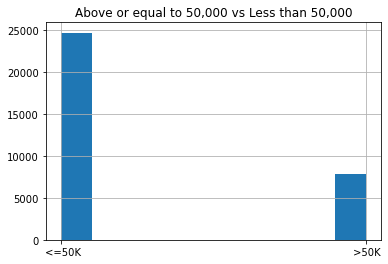

In [7]:
# checking for class imbalance
print("labels count: \n ",df["Income"].value_counts())

df["Income"].hist(grid=True)
plt.title("Above or equal to 50,000 vs Less than 50,000")
plt.show()


Data is imbalanced which needs to be balanced

# Graphical data analysis

**1.Analysing the relationship between categorical features and the label**

In [8]:
#finding categorical datas
df.select_dtypes(exclude=["number"]).columns

Index(['Workclass', 'Education', 'Marital_status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Native_country', 'Income'],
      dtype='object')

In [9]:
categorical_columns=['Workclass', 'Education', 'Marital_status', 'Occupation',
       'Relationship', 'Race', 'Sex']

--------- Workclass vs Income---------------------------------------------------------------------------------


Workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64




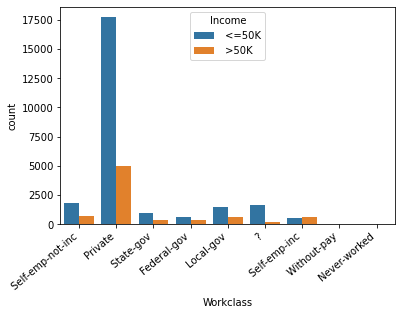

<Figure size 1080x504 with 0 Axes>

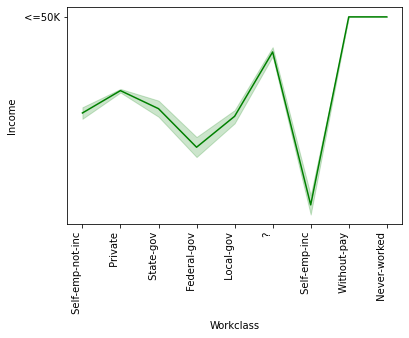

<Figure size 1080x504 with 0 Axes>

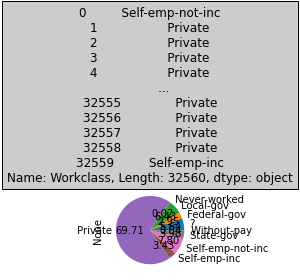

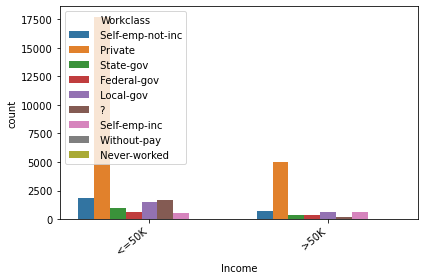



--------- Education vs Income---------------------------------------------------------------------------------


Education
 HS-grad         10501
 Some-college     7291
 Bachelors        5354
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: Education, dtype: int64




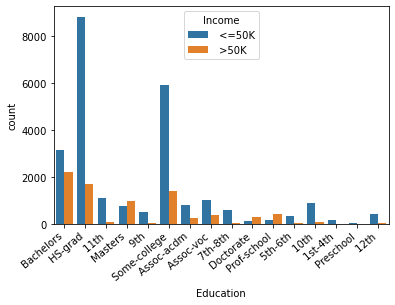

<Figure size 1080x504 with 0 Axes>

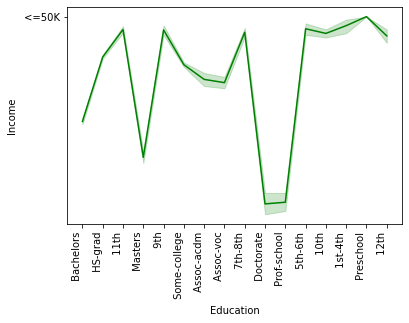

<Figure size 1080x504 with 0 Axes>

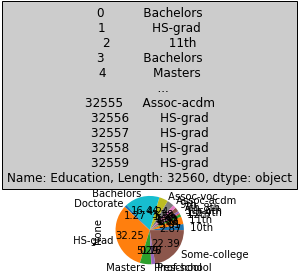

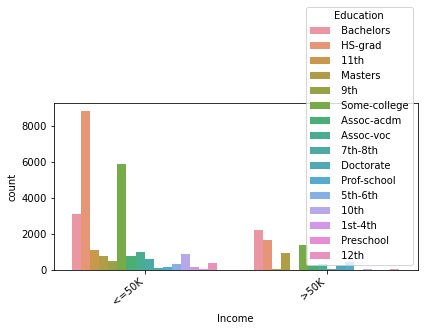



--------- Marital_status vs Income---------------------------------------------------------------------------------


Marital_status
 Married-civ-spouse       14976
 Never-married            10682
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital_status, dtype: int64




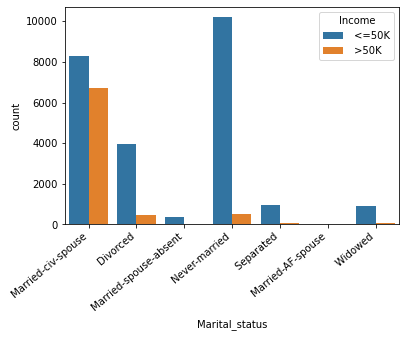

<Figure size 1080x504 with 0 Axes>

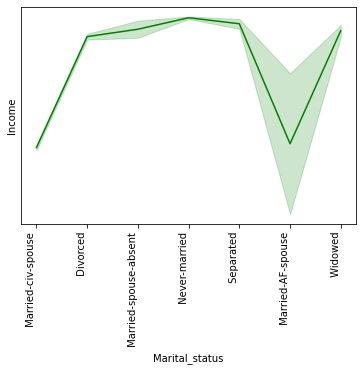

<Figure size 1080x504 with 0 Axes>

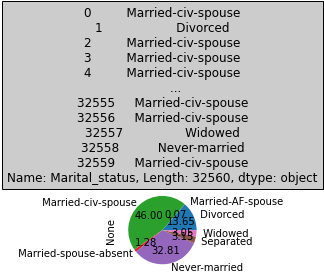

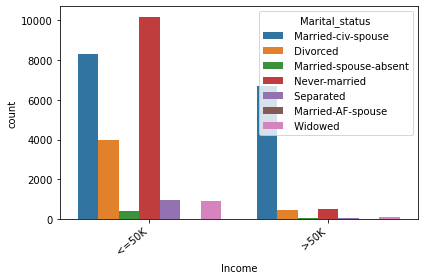



--------- Occupation vs Income---------------------------------------------------------------------------------


Occupation
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3769
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64




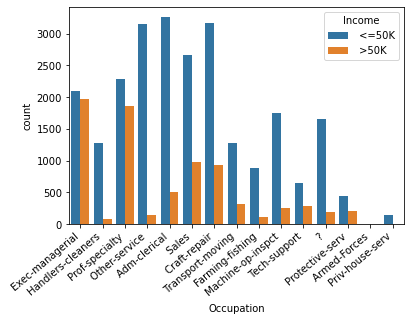

<Figure size 1080x504 with 0 Axes>

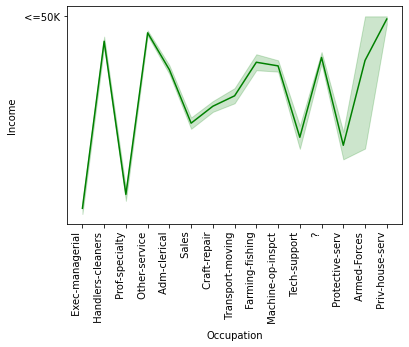

<Figure size 1080x504 with 0 Axes>

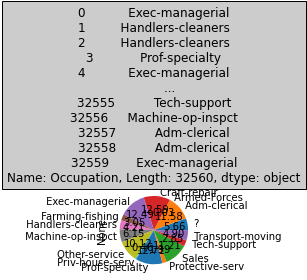

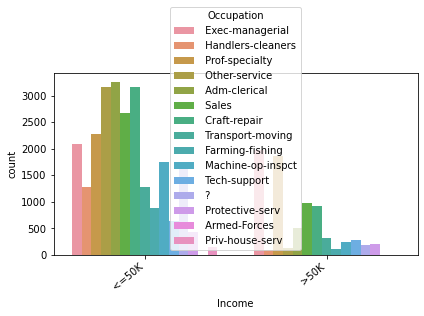



--------- Relationship vs Income---------------------------------------------------------------------------------


Relationship
 Husband           13193
 Not-in-family      8304
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: Relationship, dtype: int64




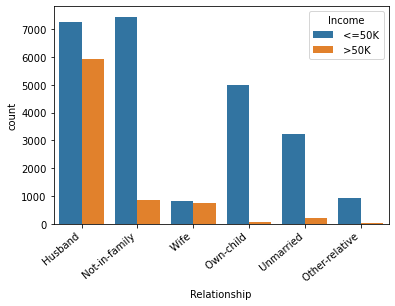

<Figure size 1080x504 with 0 Axes>

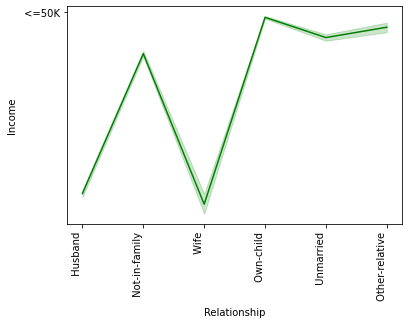

<Figure size 1080x504 with 0 Axes>

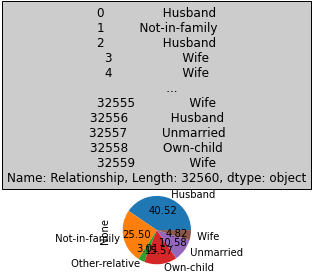

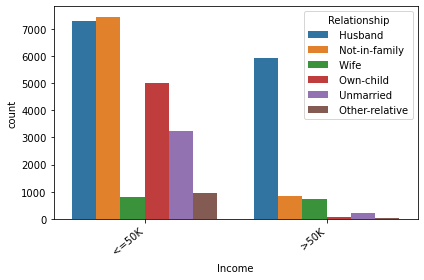



--------- Race vs Income---------------------------------------------------------------------------------


Race
 White                 27815
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: Race, dtype: int64




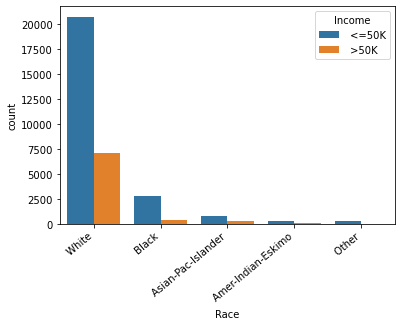

<Figure size 1080x504 with 0 Axes>

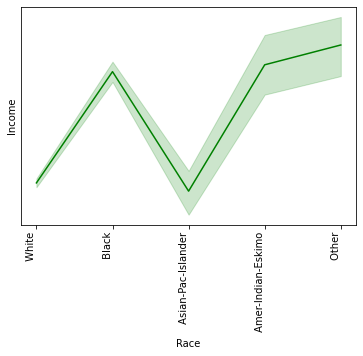

<Figure size 1080x504 with 0 Axes>

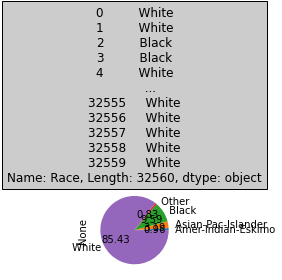

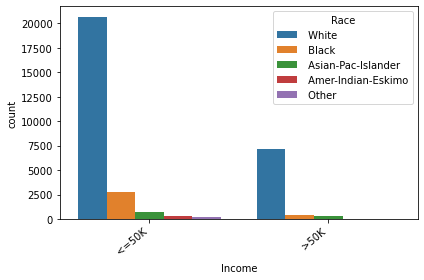



--------- Sex vs Income---------------------------------------------------------------------------------


Sex
 Male      21789
 Female    10771
Name: Sex, dtype: int64




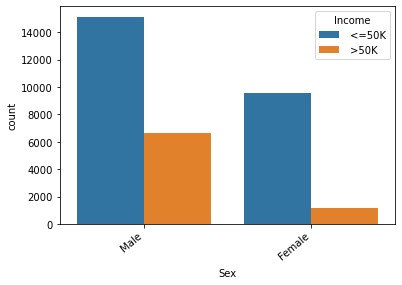

<Figure size 1080x504 with 0 Axes>

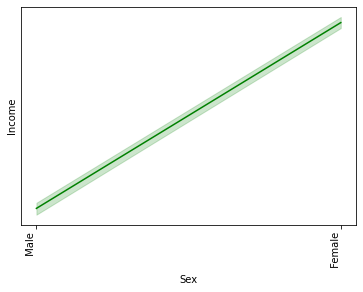

<Figure size 1080x504 with 0 Axes>

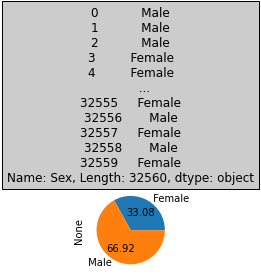

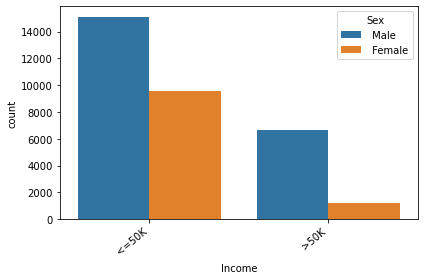

In [10]:

def relationwithlabel(x):
    print(x.value_counts())
    print("\n")
    
    #countplot with hue label
    ax=sns.countplot(x=x, hue='Income',data = df)
    plt.figure(figsize=(15,7))
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = "right")
    plt.tight_layout()
    plt.show()
    
    ay=sns.lineplot(x=x,y="Income",data=df, color='green')
    plt.figure(figsize=(15,7))
    ay.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha = "right")
    plt.tight_layout()
    plt.show()
    
    
    df.groupby(x).size().plot(kind='pie', autopct='%.2f')
    plt.title(str(x),bbox={'facecolor':'0.8', 'pad':5})
    plt.tight_layout()
    plt.show()
    
    az=sns.countplot(x='Income',hue=x,data=df)
    az.set_xticklabels(az.get_xticklabels(), rotation = 40, ha = "right")
    plt.tight_layout()
    plt.show()



for column_name in categorical_columns:
    print("---------",column_name,"vs Income---------------------------------------------------------------------------------")
    print("\n")
    print(str(column_name))
    relationwithlabel(df[str(column_name)])
    print("\n")
    

**OBSERVATION**

**Workclass vs Income**
1. Most of the respondents work in the private sector and less than 50k Income most of them work in the private sector
2. Self emplpoyed income is towards higher side
3. The highest income is for Self-emp-inc

**Education vs Income**
1. Highest 50k is seen among doctorate and Prof-school
2. Then it is seen among masters, then bachelors and after that Assoc-voc

**Marital_status vs Income**  
1. Married-civ-spouse is 14976 and Never-married is 10682
2. Married-AF-spouse and Married-civ-spouse has highest number of Greater than 50k salaries
3. Married people have highest income
4. Highest income is for married Wife with no child and married husband with no child

**Occupation vs Income**
1. Exec-managerial and Prof-specialty has highest number of Greater than 50k salaries
2. Armed-Forces has only 9,hence database doesnt cover the military servants income details well

**Relationship vs Income**
1. Wife and husbands  has highest number of Greater than 50k salaries
2. Those who have children have mostly salaries less than 50k

**Race vs Income**
1. White and Asian-Pac-Islander have highest number of Greater than 50k salaries
2. Blacks are fewer in number among respondents
3. Highest salary is for Asian Pac Islander

**Sex vs Income**
1. Males have much higher chance of getting above 50k salary


**2.Analysing the relationship between numerical features and label**

In [11]:
num=df[{'Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss',
       'Hours_per_week'}]

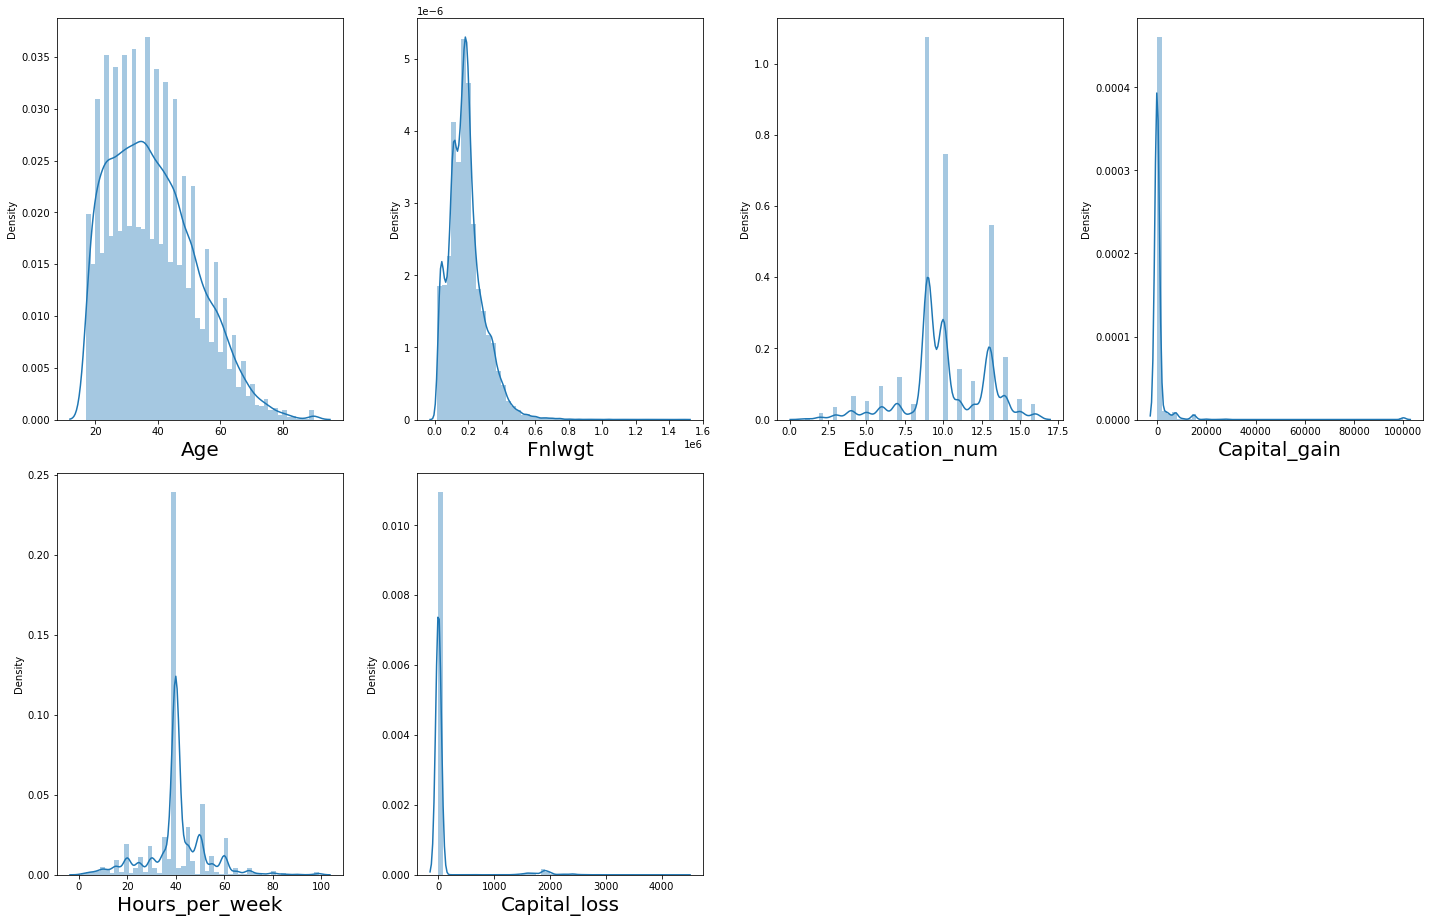

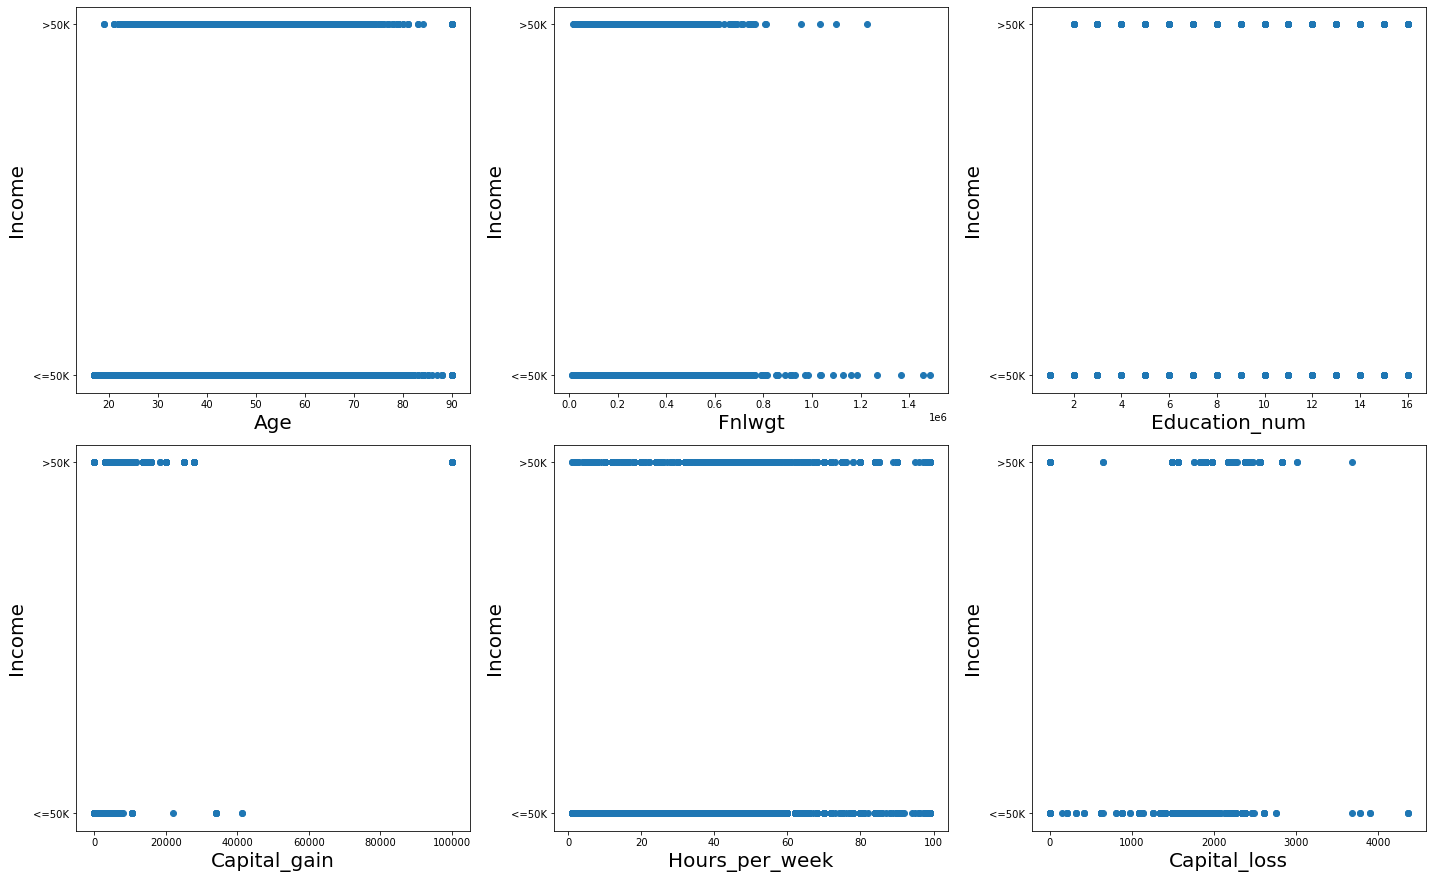

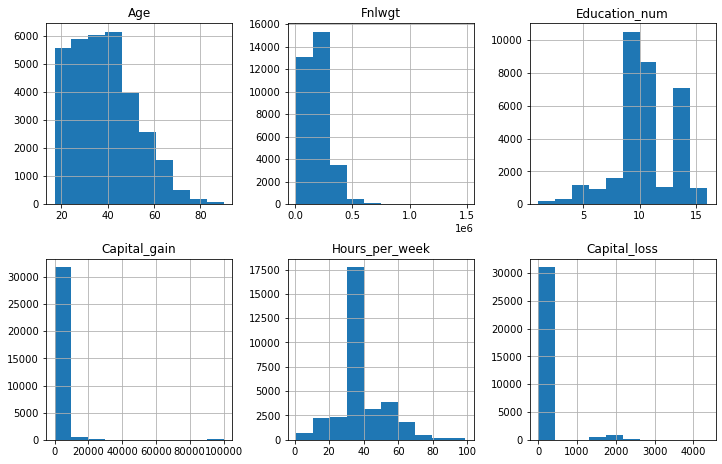

In [12]:
#understanding relationship between features and label
plt.figure(figsize=(20,25),facecolor='white')
plotnumber=1

for column in num:
    if plotnumber<=16:
       ax=plt.subplot(4,4,plotnumber)
       sns.distplot(num[column])         #distribution plot- we use for continous data
       plt.xlabel(column,fontsize=20)

    plotnumber+=1
plt.tight_layout()
plt.show()

#Analysing the relationship between numerical features and income

y_table=df['Income']

#visualising the relationship- scatter plot 
plt.figure(figsize=(20,30),facecolor='white')
plotnumber=1

for column in num:
    if plotnumber<=15:
        X=plt.subplot(5,3,plotnumber)
        plt.scatter(num[column],y_table)
        plt.xlabel(column,fontsize=20)
        plt.ylabel('Income',fontsize=20)
    plotnumber+=1
plt.tight_layout()


# Histogram- understanding the numerical data
num.hist(figsize=(12,12), layout=(3,3), sharex=False);

**OBSERVATIONS**

1. Outliers are seen in Capital gain,capital loss and Fnlwgt
2. Capital gains are upto 10,000
3. Maximum ages of the respondent is 40. The number of respondent above and below this age reduces. The maximum age of the respondent is above 90 and the minumum below 20
4. Maximum hours per week is 40
5. Most of the capital loss is below 100
6. Maximum respondents have an education of 8years. No respondent is uneducated,and maximum education is 17years
7. Impact on Income

    a. Most of the age group have same impact of salary
    
    b. When capital gains are higher, the salary is higher upto 40,000
    
    c. The Fnwlgt, capital loss, education_num and hours per week have almost the same impact on the income

# Seperating numerical and categorical datas

In [13]:
#finding numerical datas
df.select_dtypes(include=["number"]).columns

Index(['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss',
       'Hours_per_week'],
      dtype='object')

In [14]:
num=df[{'Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss',
       'Hours_per_week'}]
num.head(5)

,Age,Fnlwgt,Education_num,Capital_gain,Hours_per_week,Capital_loss
0,50,83311,13,0,13,0
1,38,215646,9,0,40,0
2,53,234721,7,0,40,0
3,28,338409,13,0,40,0
4,37,284582,14,0,40,0


In [15]:
df.select_dtypes(exclude=["number"]).columns

Index(['Workclass', 'Education', 'Marital_status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Native_country', 'Income'],
      dtype='object')

In [16]:
cat=df[{'Workclass', 'Education', 'Marital_status', 'Occupation','Relationship', 'Race', 'Sex', 'Native_country', 'Income'}]
cat.head(5)

,Education,Occupation,Income,Sex,Relationship,Native_country,Race,Workclass,Marital_status
0,Bachelors,Exec-managerial,<=50K,Male,Husband,United-States,White,Self-emp-not-inc,Married-civ-spouse
1,HS-grad,Handlers-cleaners,<=50K,Male,Not-in-family,United-States,White,Private,Divorced
2,11th,Handlers-cleaners,<=50K,Male,Husband,United-States,Black,Private,Married-civ-spouse
3,Bachelors,Prof-specialty,<=50K,Female,Wife,Cuba,Black,Private,Married-civ-spouse
4,Masters,Exec-managerial,<=50K,Female,Wife,United-States,White,Private,Married-civ-spouse


# Feature engineering

 **2.categorical columns**

In [17]:
from sklearn.preprocessing import LabelEncoder
lab_enc=LabelEncoder()

#encoding the income column
df["Income"]=lab_enc.fit_transform(df['Income'])


1 is >50K

0 is <=50K

In [18]:
cat['Workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

It has a ? in it

In [19]:
#substituting the ? with mode
df['Workclass'] = df['Workclass'].str.replace('?', 'United-States')

In [20]:
cat['Education'].value_counts()

 HS-grad         10501
 Some-college     7291
 Bachelors        5354
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: Education, dtype: int64

In [21]:
# education Category
df["Education"]= df.Education.replace(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th','10th', '11th', '12th'], 'school')
df["Education"] = df.Education.replace('HS-grad', 'high school')
df["Education"]= df.Education.replace(['Assoc-voc', 'Assoc-acdm', 'Prof-school', 'Some-college'], 'Higher Education')


Doctrate and Prof-school has highest income

In [22]:
cat['Marital_status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10682
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital_status, dtype: int64

In [23]:
df['Marital_status']= df['Marital_status'].replace(['Married-civ-spouse', 'Married-AF-spouse'], 'married')

In [24]:
cat['Occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3769
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

It has ? in it

In [25]:
df['Occupation'] = df['Occupation'].str.replace('?', 'Prof-specialty')

In [26]:
cat['Relationship'].value_counts()

 Husband           13193
 Not-in-family      8304
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: Relationship, dtype: int64

In [27]:
cat['Race'].value_counts()

 White                 27815
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: Race, dtype: int64

In [28]:
cat['Sex'].value_counts()

 Male      21789
 Female    10771
Name: Sex, dtype: int64

In [29]:
cat['Native_country'].value_counts()

 United-States                 29169
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

it has ? in it

In [30]:
df['Native_country'] = df['Native_country'].str.replace('?', 'United-States')

In [31]:
cat['Income'].value_counts()

 <=50K    24719
 >50K      7841
Name: Income, dtype: int64

class is imbalanced

1 is >50K

0 is <=50K

In [32]:
df.corr()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week,Income
Age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234039
Fnlwgt,-0.076646,1.000000,-0.043159,0.000437,-0.010259,-0.018770,-0.009481
Education_num,0.036527,-0.043159,1.000000,0.122627,0.079932,0.148127,0.335182
Capital_gain,0.077674,0.000437,0.122627,1.000000,-0.031614,0.078409,0.223333
Capital_loss,0.057775,-0.010259,0.079932,-0.031614,1.000000,0.054256,0.150523
Hours_per_week,0.068756,-0.018770,0.148127,0.078409,0.054256,1.000000,0.229690
Income,0.234039,-0.009481,0.335182,0.223333,0.150523,0.229690,1.000000


# FEATURE SELECTION

In [33]:
#finding numerical datas
df.select_dtypes(exclude=["number"]).columns

Index(['Workclass', 'Education', 'Marital_status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Native_country'],
      dtype='object')

In [34]:
num=df[{'Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss','Hours_per_week'}]

**FEATURE IMPORTANCE**

,Importance
Features,
Relationship,0.199
Fnlwgt,0.192
Age,0.123
Education_num,0.115
Capital_gain,0.111
Hours_per_week,0.074
Occupation,0.061
Workclass,0.038
Capital_loss,0.037


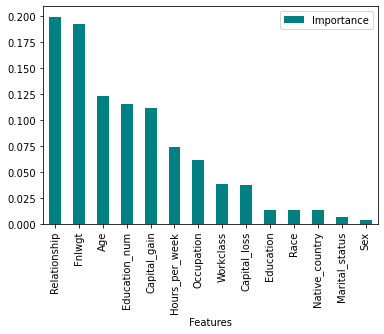

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

x1=df.drop(columns=["Income"])
y=df['Income']

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
x1['Workclass']= label_encoder.fit_transform(x1['Workclass'])
x1['Education']= label_encoder.fit_transform(x1['Education'])
x1['Marital_status']= label_encoder.fit_transform(x1['Marital_status'])
x1['Occupation']= label_encoder.fit_transform(x1['Occupation'])
x1['Relationship']= label_encoder.fit_transform(x1['Relationship'])
x1['Race']= label_encoder.fit_transform(x1['Race'])
x1['Sex']= label_encoder.fit_transform(x1['Sex'])
x1['Native_country']= label_encoder.fit_transform(x1['Native_country'])

x_train, x_test,y_train, y_test=train_test_split(x1,y,test_size=.25,random_state=199)
rf=RandomForestRegressor()
rf.fit(x_train, y_train)
importances = pd.DataFrame({'Features':x1.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='teal')
importances

Highest important feature is relationship and fnlwgt

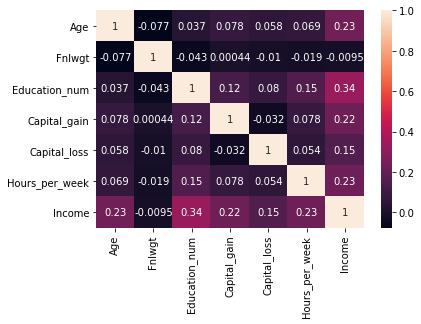

In [36]:
# Multicollinearity
sns.heatmap(df.corr(), annot=True);

Multicollineairty is not seen on the dataset

In [37]:
#vif
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

scaler=StandardScaler()
x_scaler=scaler.fit_transform(num)

vif=pd.DataFrame()
vif["quality"]=[variance_inflation_factor(x_scaler,i) for i in range(x_scaler.shape[1])]
vif["feature"]=num.columns
vif

,quality,feature
0,1.019323,Age
1,1.007768,Fnlwgt
2,1.043669,Education_num
3,1.026702,Capital_gain
4,1.031913,Hours_per_week
5,1.013467,Capital_loss


No high multicollinearity is seen among the features

1 is >50K

0 is <=50K

In [38]:
#understanding the relationship between independent variable with label
data_corr=df.corr()
data_corr["Income"].sort_values(ascending=False)

Income            1.000000
Education_num     0.335182
Age               0.234039
Hours_per_week    0.229690
Capital_gain      0.223333
Capital_loss      0.150523
Fnlwgt           -0.009481
Name: Income, dtype: float64

# EDA


**1.Duplicates**

In [39]:
#remove duplicates
df.drop_duplicates(inplace=True)

**2.Null values**

In [40]:
#checking nan
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

<AxesSubplot:>

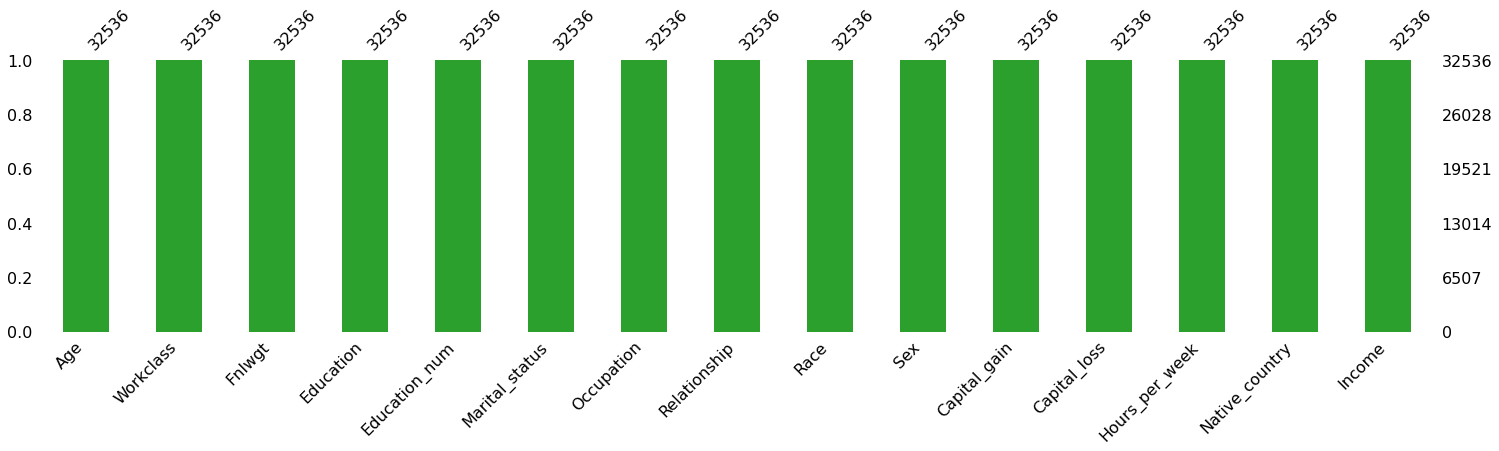

In [41]:
import missingno
missingno.bar(df, figsize = (25,5), color="tab:green")

**3.Outliers**

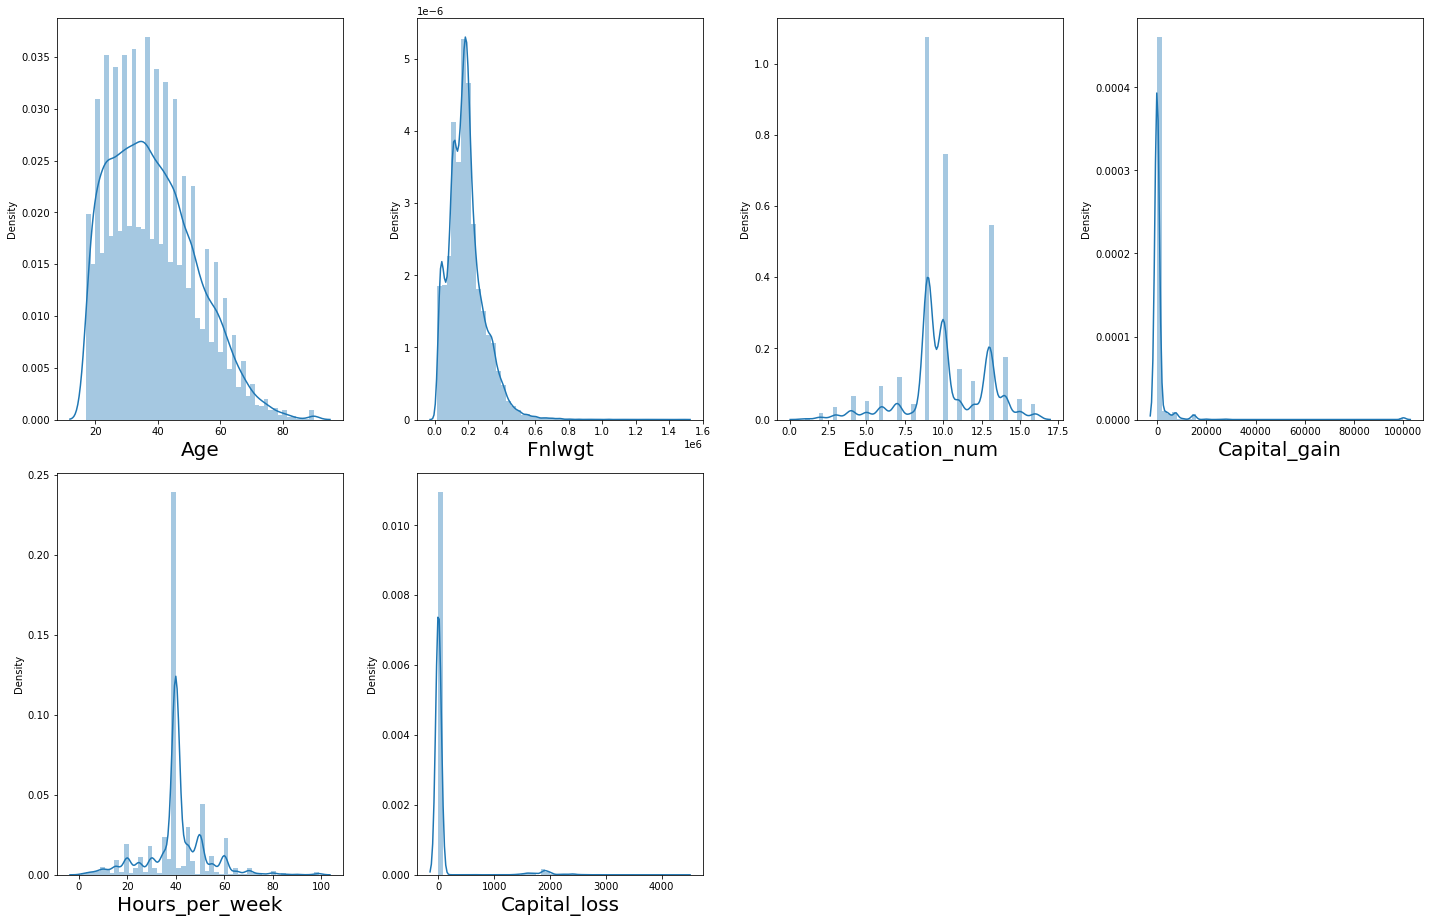

In [42]:
#checking for outliers
plt.figure(figsize=(20,25),facecolor='white')
plotnumber=1

for column in num:
    if plotnumber<=16:
       ax=plt.subplot(4,4,plotnumber)
       sns.distplot(num[column])         #distribution plot- we use for continous data
       plt.xlabel(column,fontsize=20)

    plotnumber+=1
plt.tight_layout()
plt.show()


In [43]:
n= df[['Capital_gain', 'Capital_loss','Fnlwgt']]

In [44]:
#finding and reducing outliers and skewness

#Using zscore
import numpy as np
from scipy.stats import zscore

z=np.abs(zscore(n))
threshold=3
df_new=df[(z<3).all(axis=1)]

print("columns before applying zscore: ",len(df))
print("columns after applying zscore: ",len(df_new))

columns before applying zscore:  32536
columns after applying zscore:  30517


In [46]:
df_new

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [47]:
df=df_new

In [48]:
df

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [49]:
df.skew()

Age                0.572775
Fnlwgt             0.632532
Education_num     -0.320314
Capital_gain       4.955570
Capital_loss      29.827819
Hours_per_week     0.225871
Income             1.335359
dtype: float64

Capital_gain and capital_loss has very high skewness

In [53]:
#removing skewness using log1p
sk=df[{'Capital_gain', 'Capital_loss'}]

for col in sk:
    if sk.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

In [54]:
df

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0.0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0.000000,0.0,38,United-States,0
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.000000,0.0,40,United-States,1
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0.000000,0.0,40,United-States,0
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0.000000,0.0,20,United-States,0


In [55]:
df.skew()

Age                0.572775
Fnlwgt             0.632532
Education_num     -0.320314
Capital_gain       3.082362
Capital_loss      24.947599
Hours_per_week     0.225871
Income             1.335359
dtype: float64

After applying transform also the skewness is high, hence if the accuracy is too low we can drop it

# Encoding

In [56]:
#label encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['Workclass']= label_encoder.fit_transform(df['Workclass'])
df['Education']= label_encoder.fit_transform(df['Education'])
df['Marital_status']= label_encoder.fit_transform(df['Marital_status'])
df['Occupation']= label_encoder.fit_transform(df['Occupation'])
df['Relationship']= label_encoder.fit_transform(df['Relationship'])
df['Race']= label_encoder.fit_transform(df['Race'])
df['Sex']= label_encoder.fit_transform(df['Sex'])
df['Native_country']= label_encoder.fit_transform(df['Native_country'])

#standardising the data for PCA
x=df.drop(columns=["Income"])
y=df['Income']

# Finding best random state

In [57]:
from sklearn.linear_model import LogisticRegression
maxAccu=0
maxRS=0

for i in range(1,200):
    x_train, x_test,y_train, y_test=train_test_split(x,y,test_size=.25,random_state=i)
    LR=LogisticRegression()
    LR.fit(x_train,y_train)
    predrf=LR.predict(x_test)
    acc=accuracy_score(y_test,predrf)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i

print("Best accuracy is", maxAccu,"on Random State",maxRS)

Best accuracy is 0.8011795543905635 on Random State 141


The lucky number is 141

# Splitting data

In [58]:
 #splitting the data into train and test
from sklearn.model_selection import train_test_split

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, Y_train, Y_rem = train_test_split(x,y, train_size=0.8,random_state=141)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem,Y_rem, test_size=0.5)

In [59]:
print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(24413, 14)
(24413,)
(3052, 14)
(3052,)
(3052, 14)
(3052,)


(None, None)

In [60]:
X_train

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country
27453,35,3,310290,11,9,2,13,5,2,0,0.0,0.0,40,37
20495,32,3,425622,11,9,2,13,0,4,1,0.0,0.0,55,37
6764,28,3,38918,15,10,2,2,0,4,1,0.0,0.0,50,10
4413,51,3,194908,11,9,4,0,1,4,0,0.0,0.0,40,37
20023,32,1,186993,11,9,2,13,0,4,1,0.0,0.0,40,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15091,18,3,400616,15,10,4,0,3,4,1,0.0,0.0,40,37
15955,59,3,233312,15,10,2,2,0,4,1,0.0,0.0,40,37
12058,40,1,180123,11,9,3,4,3,2,1,0.0,0.0,40,37
604,48,3,45612,11,9,4,0,4,2,0,0.0,0.0,37,37


# Sampling the data to avoid over or underfitting

In [61]:

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [62]:
#handling imbalanced data through smote technique
from collections import Counter
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=0)
oversample = SMOTE()
X_train_SMOTE, Y_train_SMOTE= oversample.fit_resample(X_train, Y_train)



In [63]:
print(Y_train_SMOTE)
print(X_train_SMOTE)

0        0
1        0
2        1
3        0
4        0
        ..
37857    1
37858    1
37859    1
37860    1
37861    1
Name: Income, Length: 37862, dtype: int32
       Age  Workclass  Fnlwgt  Education  Education_num  Marital_status  \
0       35          3  310290         11              9               2   
1       32          3  425622         11              9               2   
2       28          3   38918         15             10               2   
3       51          3  194908         11              9               4   
4       32          1  186993         11              9               2   
...    ...        ...     ...        ...            ...             ...   
37857   49          3  156921          7             10               0   
37858   47          0  219290         10              9               2   
37859   29          3  168478         11             13               2   
37860   50          3  145413         10             13               2   
37861   36  

After oversampling data became negative, hence not using it

# Modelling

**Training the model**

In [64]:
KNN=KNeighborsClassifier(n_neighbors=6)
DT=DecisionTreeClassifier(random_state=6)
XGB=XGBClassifier()
RF=RandomForestClassifier()
ADA=AdaBoostClassifier()
MNB=MultinomialNB()
GBC=GradientBoostingClassifier()
BC=BaggingClassifier()
ETC=ExtraTreesClassifier()
LR=LogisticRegression()

models= []
models.append(('KNeighborsClassifier', KNN))
models.append(('DecisionTreeClassifier', DT))
models.append(('XGBClassifier', XGB))
models.append(('RandomForestClassifier', RF))
models.append(('AdaBoostClassifier', ADA))
models.append(('MultinomialNB', MNB))
models.append(('GradientBoostingClassifier', GBC))
models.append(('BaggingClassifier', BC))
models.append(('ExtraTreesClassifier', ETC))
models.append(('LogisticRegression', LR))

****************************************** KNeighborsClassifier ********************************************************


KNeighborsClassifier(n_neighbors=6)


Accuracy_score =  0.6366317169069463


Cross_Val_Score =  0.7785117325618772


roc_auc_score =  0.5745871676891615


classification_report
               precision    recall  f1-score   support

           0       0.82      0.68      0.75      2400
           1       0.29      0.47      0.35       652

    accuracy                           0.64      3052
   macro avg       0.56      0.57      0.55      3052
weighted avg       0.71      0.64      0.66      3052



[[1639  761]
 [ 348  304]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)



****************************************** DecisionTreeClassifier ********************************************************


DecisionTreeClassifier(random_state=6)


Accuracy_score =  0.786697247706422


Cross_Val_Score =  0.7896399871423979


roc_auc_score =  0.7074258691206544


classificatio

GradientBoostingClassifier()


Accuracy_score =  0.8351900393184797


Cross_Val_Score =  0.8577927783135111


roc_auc_score =  0.7835007668711658


classification_report
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2400
           1       0.60      0.69      0.64       652

    accuracy                           0.84      3052
   macro avg       0.76      0.78      0.77      3052
weighted avg       0.85      0.84      0.84      3052



[[2097  303]
 [ 200  452]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)



****************************************** BaggingClassifier ********************************************************


BaggingClassifier()


Accuracy_score =  0.8286369593709043


Cross_Val_Score =  0.8315889853209043


roc_auc_score =  0.734092535787321


classification_report
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      2400
           1       0.61      0.57  

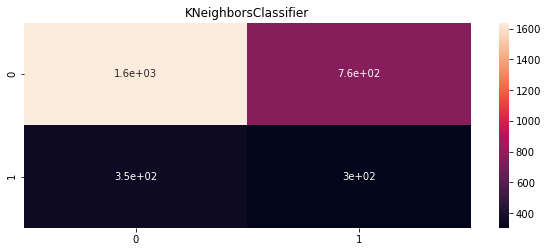

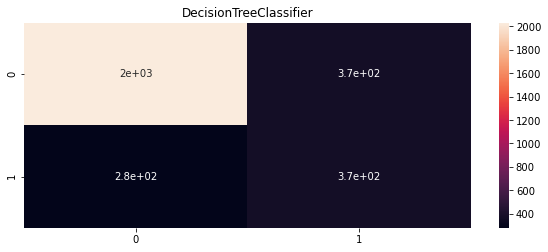

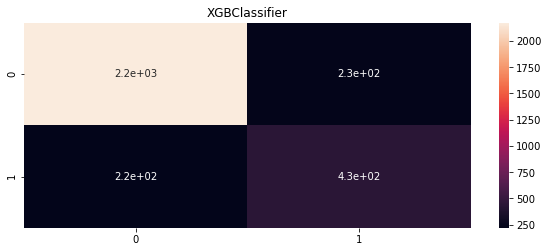

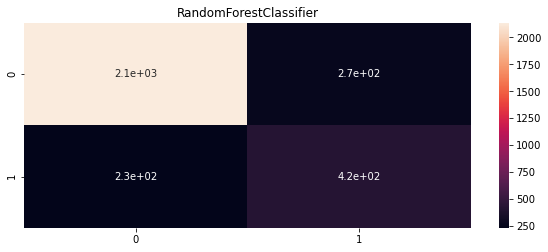

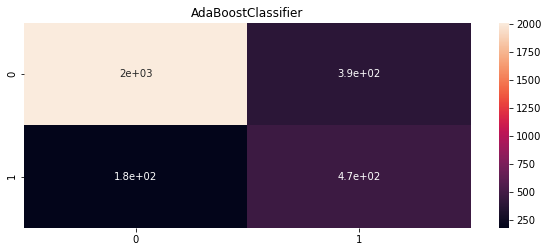

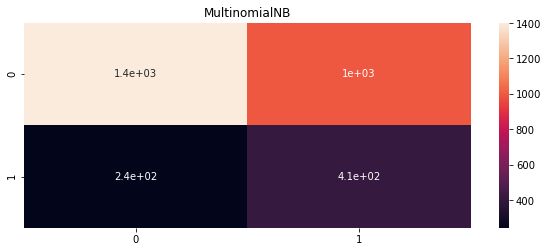

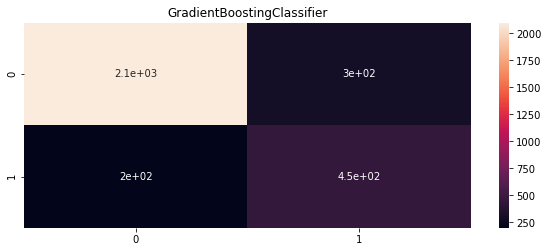

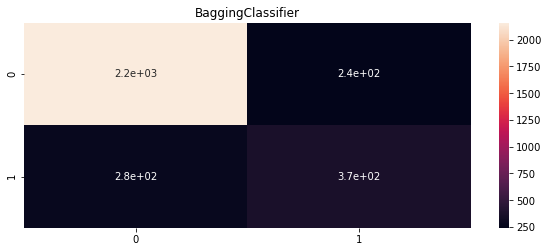

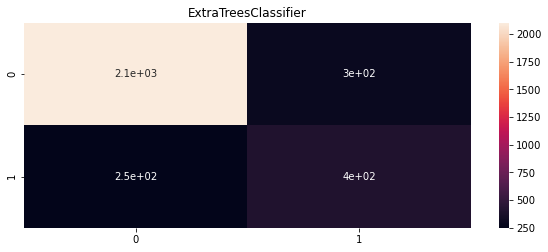

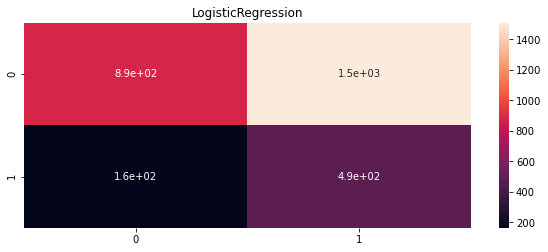

In [66]:
Model= []
score= []
cvs=[]
rocscore=[]
difference=[]
for name,model in models:
    print('******************************************',name,'********************************************************')
    print('\n')
    Model.append(name)
    model.fit(X_train_SMOTE,Y_train_SMOTE)
    print(model)
    pre=model.predict(X_test)
    print('\n')
    
    AS=accuracy_score(Y_test,pre)
    print('Accuracy_score = ',AS)
    score.append(AS*100)
    print('\n')
    
    sc= cross_val_score(model, X_valid,Y_valid, cv=10, scoring='accuracy').mean()
    print('Cross_Val_Score = ',sc)
    cvs.append(sc*100)
    print('\n')
    
    
    false_positive_rate, true_positive_rate,thresolds= roc_curve(Y_test,pre)
    roc_auc=auc(false_positive_rate,true_positive_rate)
    print('roc_auc_score = ', roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')
    
    print('classification_report\n',classification_report(Y_test,pre))
    print('\n')
    
    cm=confusion_matrix(Y_test,pre)
    print(cm)
    print('\n')
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    print(sns.heatmap(cm,annot=True))
    print('\n\n')
    diff=AS-sc
    difference.append(diff)

In [67]:
result = pd.DataFrame({'Model': Model, 'Accuracy_score': score,'Cross_val_score': cvs,'difference between a and c':difference,'roc_score':rocscore})
result

,Model,Accuracy_score,Cross_val_score,difference between a and c,roc_score
0,KNeighborsClassifier,63.663172,77.851173,-0.141880,57.458717
1,DecisionTreeClassifier,78.669725,78.963999,-0.002943,70.742587
2,XGBClassifier,85.353866,84.009322,0.013445,78.455521
3,RandomForestClassifier,83.650066,84.665488,-0.010154,76.646089
4,AdaBoostClassifier,81.258191,85.189757,-0.039316,78.029652
5,MultinomialNB,59.305374,61.204757,-0.018994,60.496677
6,GradientBoostingClassifier,83.519004,85.779278,-0.022603,78.350077
7,BaggingClassifier,82.863696,83.158899,-0.002952,73.409254
8,ExtraTreesClassifier,82.110092,84.043287,-0.019332,74.773262
9,LogisticRegression,45.117955,78.538734,-0.334208,55.888292


# ROC AUC curve

AxesSubplot(0.125,0.808774;0.62x0.0712264)



AxesSubplot(0.125,0.808774;0.62x0.0712264)



[23:46:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AxesSubplot(0.125,0.808774;0.62x0.0712264)



AxesSubplot(0.125,0.808774;0.62x0.0712264)



AxesSubplot(0.125,0.808774;0.62x0.0712264)



AxesSubplot(0.125,0.808774;0.62x0.0712264)



AxesSubplot(0.125,0.808774;0.62x0.0712264)



AxesSubplot(0.125,0.808774;0.62x0.0712264)



AxesSubplot(0.125,0.808774;0.62x0.0712264)



AxesSubplot(0.125,0.808774;0.62x0.0712264)





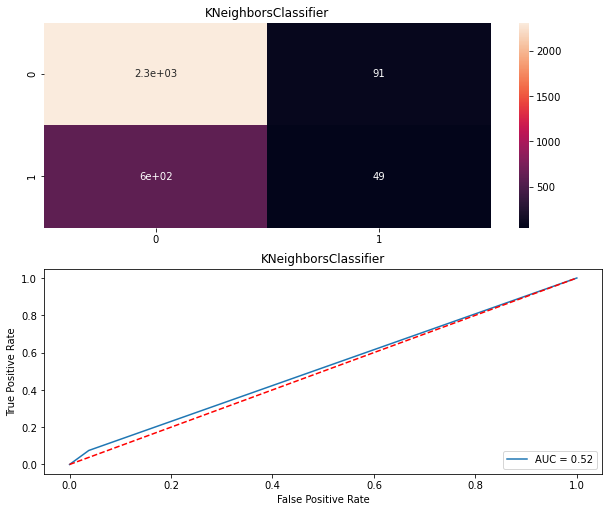

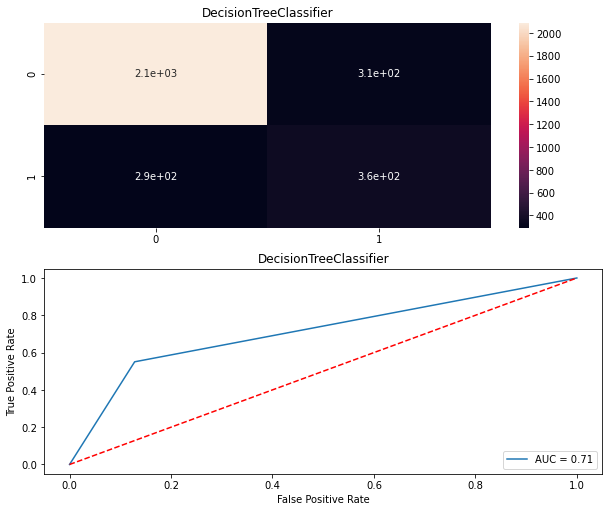

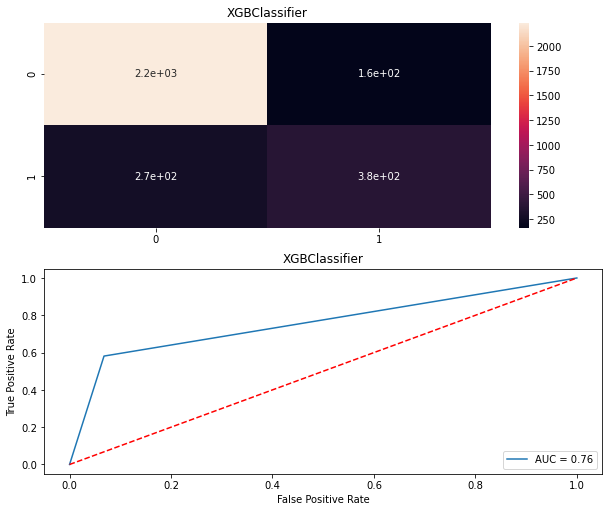

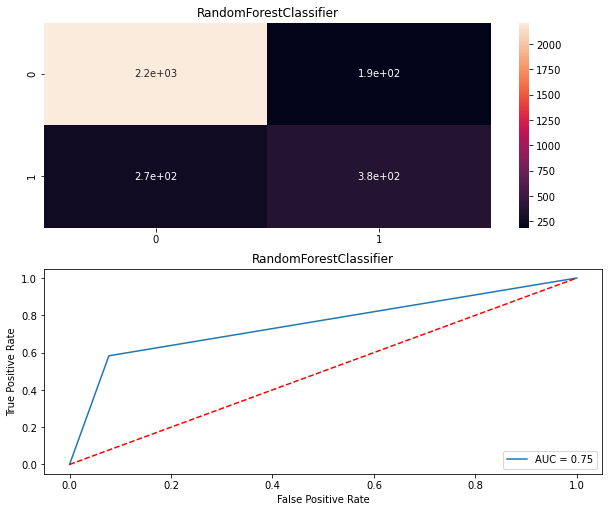

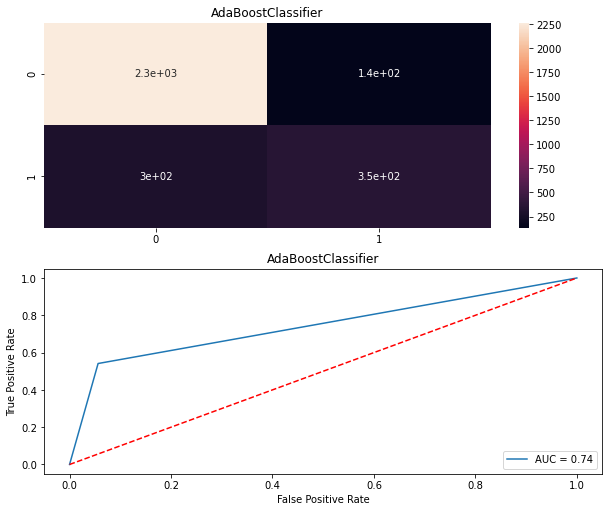

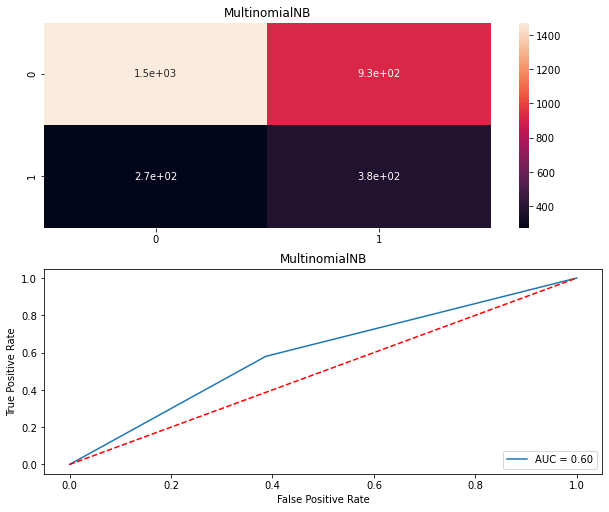

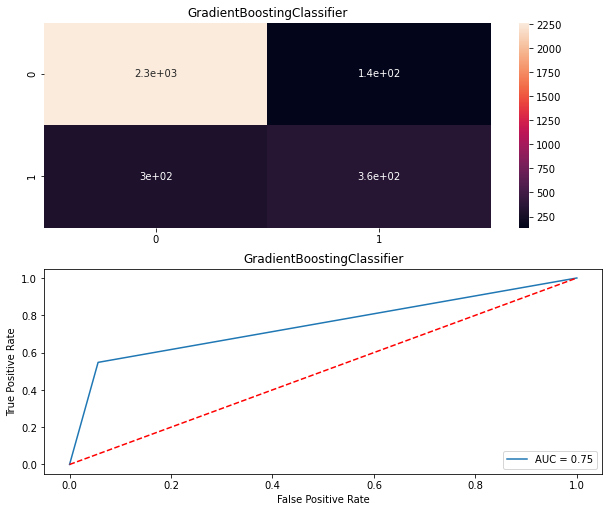

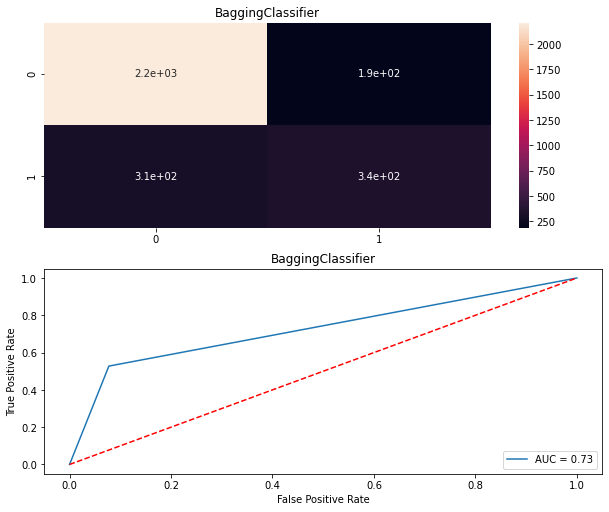

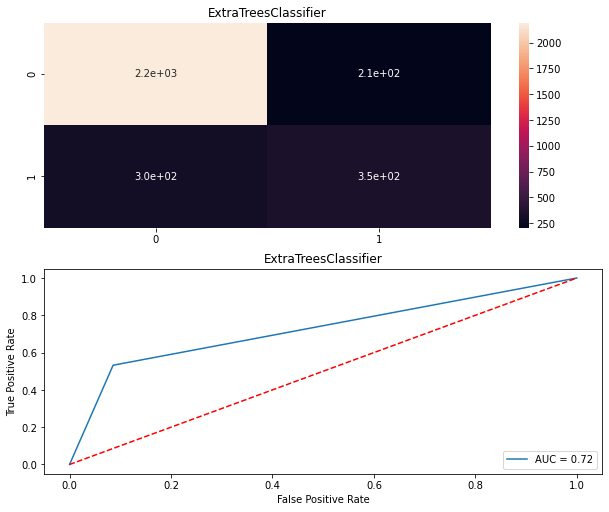

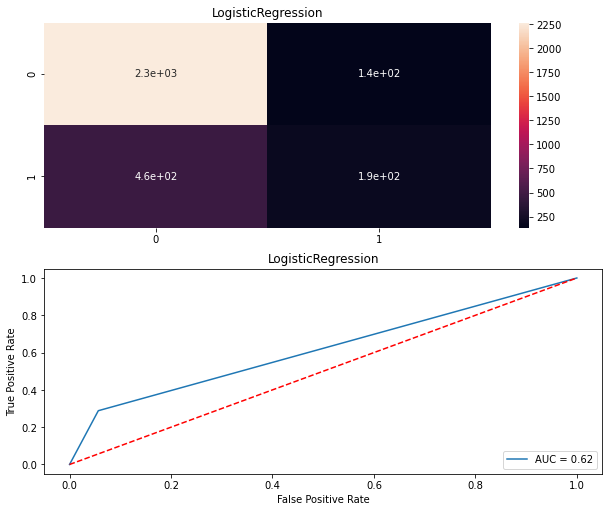

In [68]:
for name,model in models:
    model.fit(X_train,Y_train)
    pre=model.predict(X_test)

    false_positive_rate, true_positive_rate,thresolds= roc_curve(Y_test,pre)
    roc_auc=auc(false_positive_rate,true_positive_rate)
    
    cm= confusion_matrix(Y_test,pre)
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    print(sns.heatmap(cm,annot=True))
    plt.subplot(912)
    plt.title(name)
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    print('\n\n')

# Best model chosen

The best model chosen is XGB Booster with highest accuracy and least fitting problem.
Further it is also one of the best models for classification

# Hyperparameter tuning

In [71]:
#HyperParameter tuning
from sklearn.model_selection import GridSearchCV

fmod_param = {'base_score':[0.5,1,1.5,2], 'colsample_bylevel':[1,1.25,1.5,2],'colsample_bytree':[1,2,3],
       'gamma':[0,1,2,3], 'learning_rate':[0.1,0.5,1,1.5,2]}
             
GSCV = GridSearchCV(XGBClassifier(), fmod_param, cv=5)
GSCV.fit(X_train,Y_train)
GSCV.best_params_

[00:20:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:20:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:20:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:20:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:21:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 2,
 'learning_rate': 0.1}

In [73]:
Final_model=XGBClassifier(base_score=0.5,colsample_bylevel=1,colsample_bytree= 1,gamma= 2,learning_rate= 0.1)

In [74]:
Final_model.fit(x_train,y_train)
pred=Final_model.predict(x_test)
print(accuracy_score(y_test,pred)*100)

[09:30:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
86.56618610747051


[09:30:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AxesSubplot(0.125,0.808774;0.62x0.0712264)





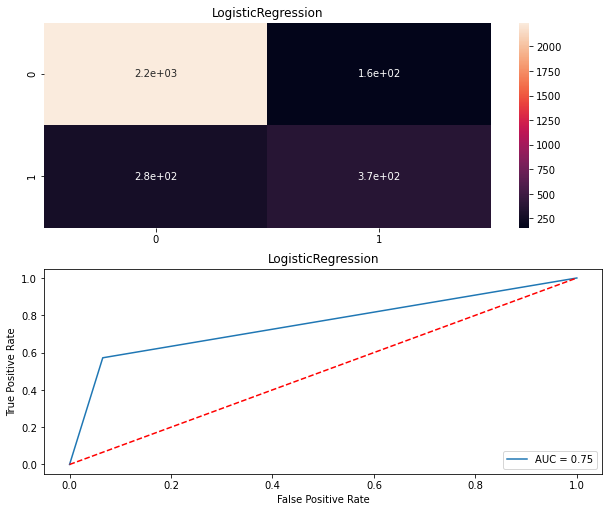

In [75]:
Final_model.fit(X_train,Y_train)
pre=Final_model.predict(X_test)

false_positive_rate, true_positive_rate,thresolds= roc_curve(Y_test,pre)
roc_auc=auc(false_positive_rate,true_positive_rate)

cm= confusion_matrix(Y_test,pre)
plt.figure(figsize=(10,40))
plt.subplot(911)
plt.title(name)
print(sns.heatmap(cm,annot=True))
plt.subplot(912)
plt.title(name)
plt.plot(false_positive_rate, true_positive_rate, label='AUC = %0.2f'% roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print('\n\n')

In [76]:
score_final_model=[]
cvs_final_model=[]
rocscore_final_model=[]

pre=Final_model.predict(X_test)

AS=accuracy_score(Y_test,pre)
score_final_model.append(AS*100)


sc= cross_val_score(Final_model, X_test,Y_test, cv=10, scoring='accuracy').mean()
cvs_final_model.append(sc*100)


false_positive_rate, true_positive_rate,thresolds= roc_curve(Y_test,pre)
roc_auc=auc(false_positive_rate,true_positive_rate)
rocscore_final_model.append(roc_auc*100)


print('classification_report\n',classification_report(Y_test,pre))
print('\n')

print("Score of the finalized model:")
final_model_scores=data = pd.DataFrame({'Accuracy score':score_final_model,'cross validation score':cvs_final_model,'ROC Score':rocscore_final_model})

from IPython.display import HTML
HTML(final_model_scores.to_html(index=False))

[09:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Accuracy score,cross validation score,ROC Score
85.714286,84.861995,75.333461


# Saving model

In [80]:
#Saving the best  ML model

# save the model to disk
model_file_path='FinalModel_census_income.pkl'
pickle.dump(Final_model, open(model_file_path, 'wb'))



-------------------------------------------------------------------------------------MODEL BUILT-------------------------------------------------------------------------------------------------